# UDF f105w image

## Import libraries

In [231]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse

In [232]:
#additional setup for reading test image and displaying plots
%matplotlib inline
rcParams['figure.figsize'] = [10.,8.]

## Read image data and show

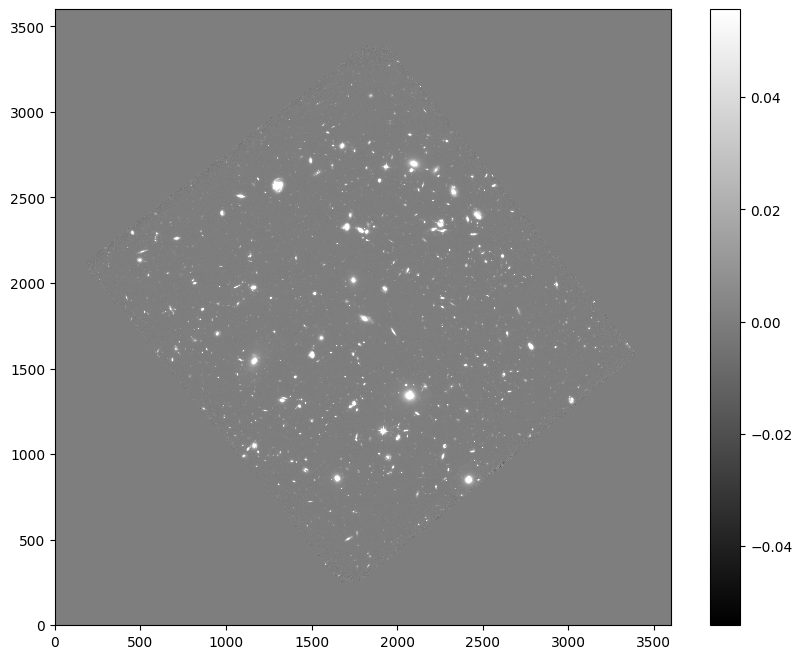

In [233]:
# read image using aif into a standard 2-d numpy array
hdul = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")   #open file
data = hdul[0].data  #read file
data = data.byteswap(inplace=True).newbyteorder()   #avoid byte error
#steps to show image
m, s = np.mean(data), np.std(data)   # define variables
plt. imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')   #show image
plt.colorbar();   #add a color bar legend

## Subtract Background

In [234]:
# measure a spatially varying backround on the image  
bkg = sep.Background(data)
# mask pixels
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)

In [235]:
# get a global mean and noise of the background
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [236]:
# background --> 2-d array (same size as og image)
bkg_image = np.array(bkg) 

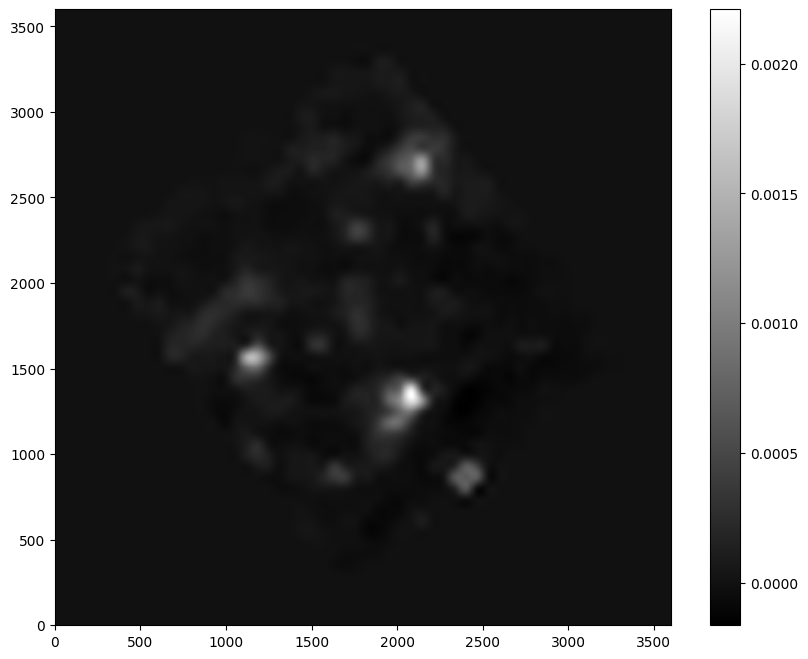

In [237]:
# show the backround image
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')  # show image
plt.colorbar();  # show color bar

## Show Backround noise

In [238]:
# backround noise --> 2-d array
bkg_rms = bkg.rms()

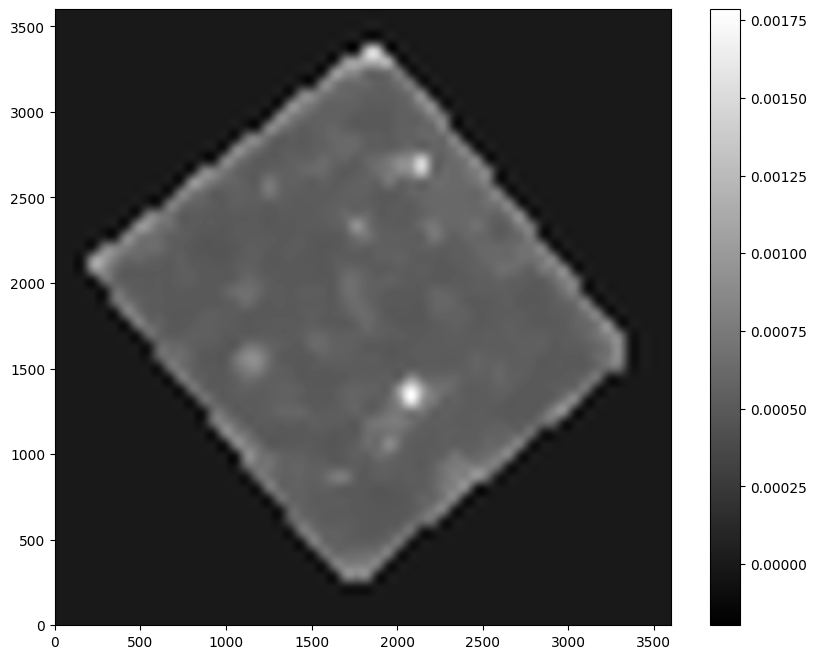

In [239]:
# show the backround noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')  #show the image
plt.colorbar();  #show the colorbar

In [240]:
# subtract the backround
data_sub = data - bkg

## Object Detection

In [241]:
# run object detection on the background-subtracted data image
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [242]:
# # of objects detected = 
print(f"Number of sources = {len(objects)}")

Number of sources = 8646


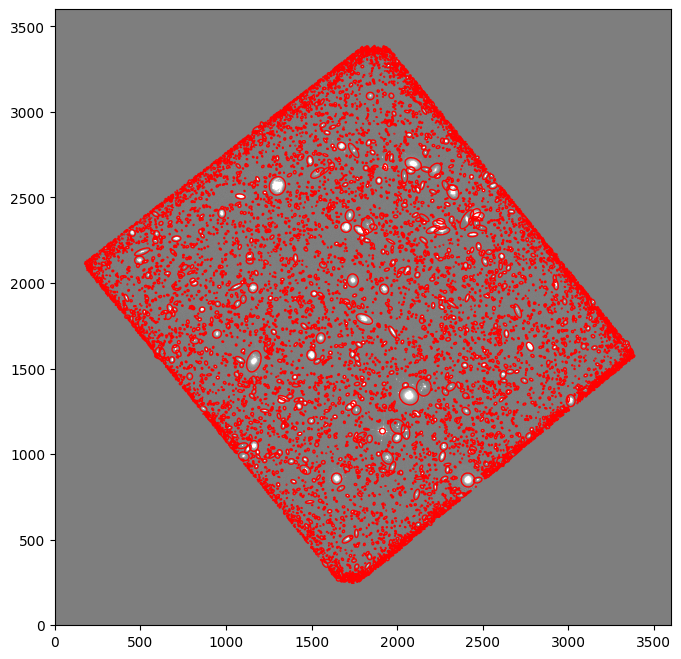

In [243]:
# plot the background subtracted image
fig, ax = plt.subplots()   #make plot
m, s = np.mean(data_sub), np.std(data_sub)   # define variables
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')  # show image

# plot an ellipse for each object
for i in range (len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),    #define the parts of the ellpise
               width=6*objects['a'][i],
               height=6*objects['b'][i],
               angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [244]:
# display avalible feilds
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Apreture Photometry

In [245]:
# preforming simple circular apreture photometry with a 
# 3-pizel radius at the objects
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 
                                    3.0, err=bkg.globalrms, gain=1.0)

In [246]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


## Histogram of source fluxes

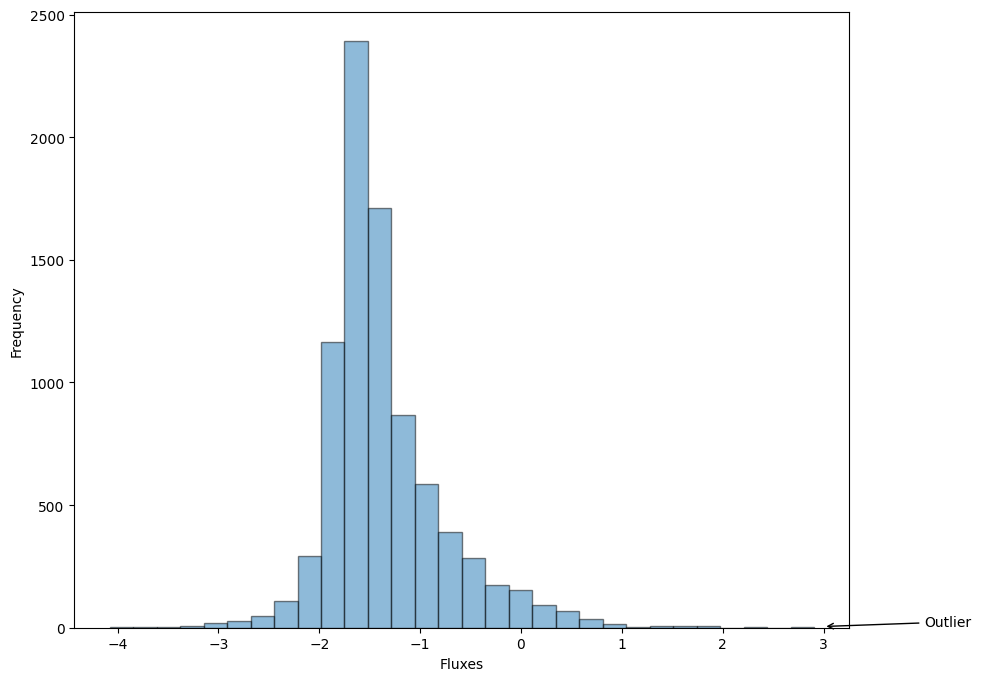

In [247]:
#make a histogram
plt.hist(np.log10(flux[flux>0]), bins=30, alpha=0.5, edgecolor='black') #histogram with a log axis
plt.xlabel('Fluxes')   # make x label
plt.ylabel('Frequency')  #make y label

#make an arrow pointing to the outlier
arrow_point = (3, 5)
plt.annotate('Outlier', xy=arrow_point, xytext=(arrow_point[0] + 1, arrow_point[1] + 2),
             arrowprops=dict(facecolor='red', arrowstyle='->'))
#show histogram
plt.show()

##Statistical Operations on flux data

In [248]:
#calculate mean
mean = np.mean(flux)
print(f"The mean of the distribution is {mean}")

#calculate median
median = np.median(flux)
print(f"The median of the distribution is {median}")

#calculate outlier
outlier = np.max(flux)
print(f"The outlier of the distribution is {outlier}")

#calculate # of standard deviations
std = np.std(flux)
print(f"The standard deviation of the distribution is {std}")
num_std = (outlier - mean) / std
print(f"The outlier is {num_std} standard deviations from the mean")


The mean of the distribution is 0.36159539075495284
The median of the distribution is 0.03097589430617518
The outlier of the distribution is 807.2972835731507
The standard deviation of the distribution is 9.24028235192194
The outlier is 87.32803365197564 standard deviations from the mean


## Making a 3-color false image 

Combining data from F105w, F125w, F160w 

## Read in the images

In [249]:
#define file names
fdata_F105w = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
fdata_F125w = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_F160w = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

#read data
hdu_2 = fits.open(fdata_F105w)
hdu_3 = fits.open(fdata_F125w)
hdu_4 = fits.open(fdata_F160w)

#retrive image data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

In [250]:
# Look at the data

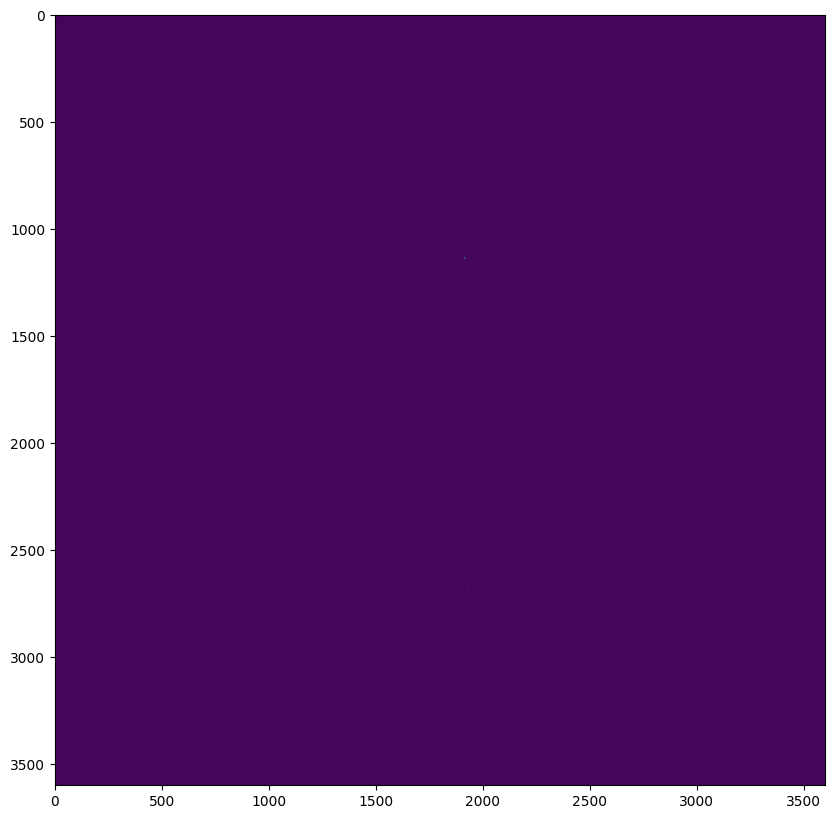

In [251]:
f = plt.figure(figsize=(10,10))
plt.imshow(data_2)

## Rescale the data

In [252]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

## Check rescaled data by plotting

In [253]:
def fits_quicklook(data,fnx=10, fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin, vmax=vpmax)

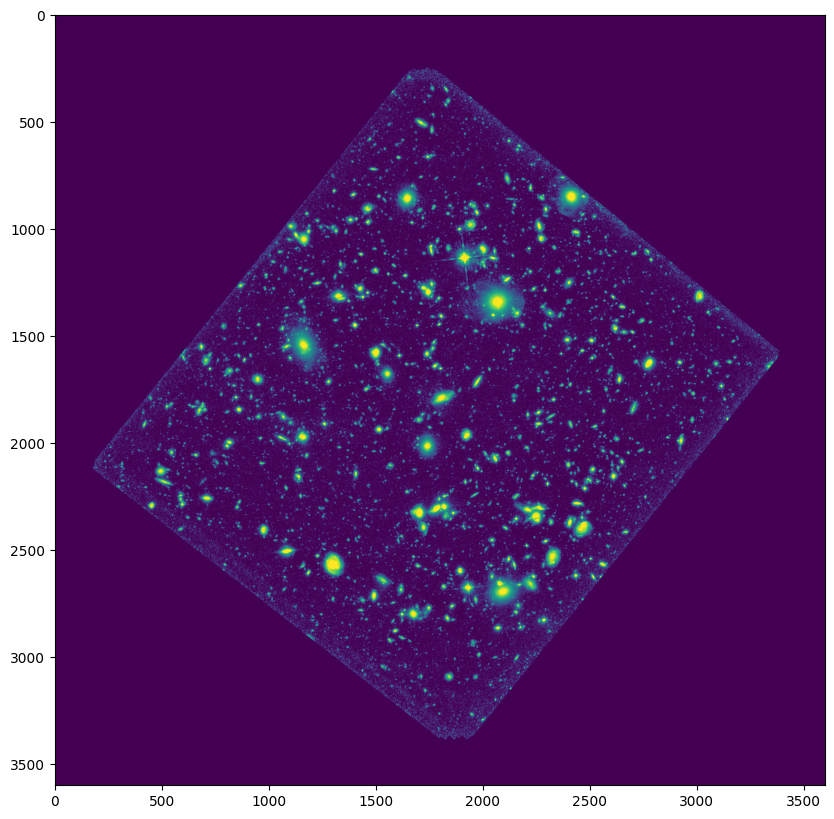

In [254]:
#show the image
fits_quicklook(data_2)

## Make the 3-color image

In [255]:
#Use resacled images
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

In [256]:
#Limit the data to be between the min and the max values in the rescaled data
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res<d2min] = d3min
data_3_res[data_3_res>d2max] = d3max
data_4_res[data_4_res<d2min] = d4min
data_4_res[data_4_res>d2max] = d4max

In [257]:
#Define areas of RGB image
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1], 3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

## Show and save the Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


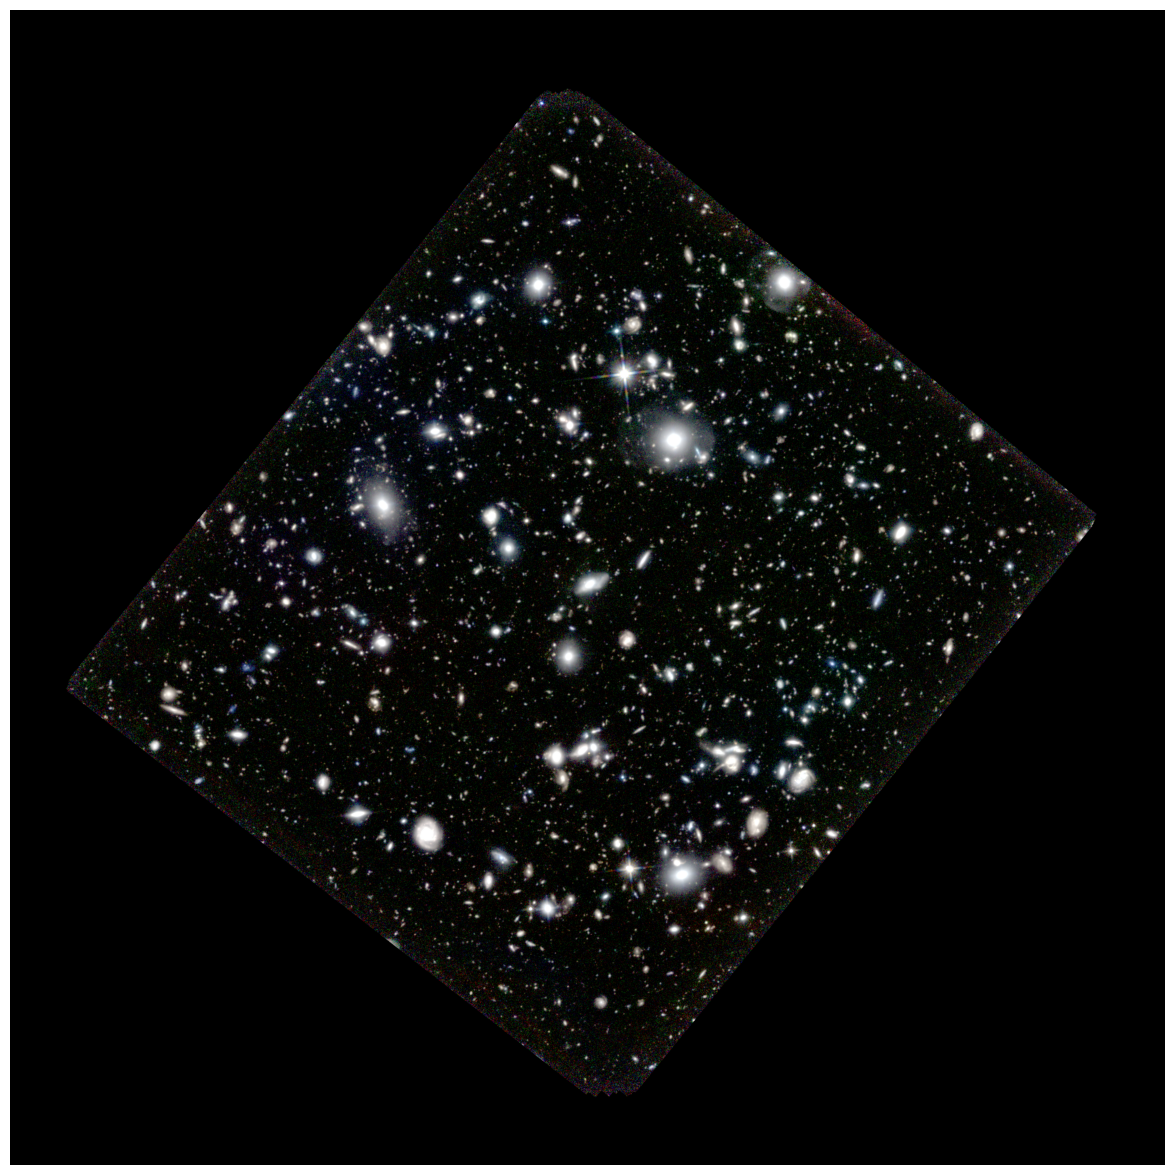

In [258]:
f, ax = plt.subplots(1,1, figsize=(15,15))   #define figure
ax.axis('off')   #turn off axis
ax.imshow(rgb)  #show image

#save figure
plt.savefig('FP_comb_img.png', bbox_inches='tight', pad_inches=0, dpi=660)